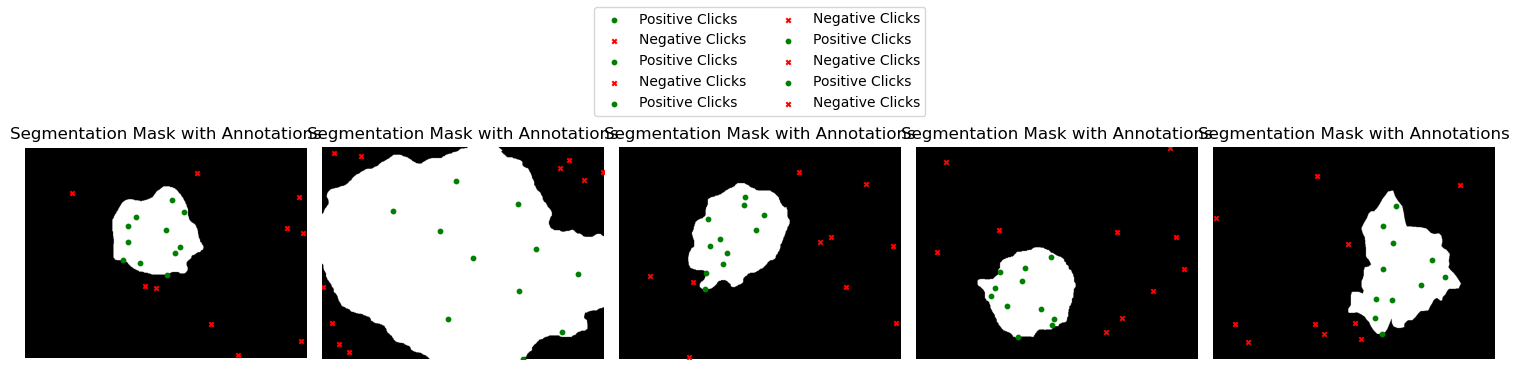

In [3]:
import os
import numpy as np
import glob
import random
from PIL import Image
import torch
from torch.utils.data import Dataset
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

class SkinLesionLoader(Dataset):
    def __init__(self, transform, dataset_path, split='train'):
        'Initialization'
        self.transform = transform  # This transformation is for the input image only.
        
        # Collect all image paths and label paths
        self.image_paths = []
        self.label_paths = []

        # Loop through all IMG### folders
        for folder_name in os.listdir(dataset_path):
            folder_path = os.path.join(dataset_path, folder_name)
            if os.path.isdir(folder_path):
                # Add dermoscopic image path
                dermoscopic_image_path = os.path.join(folder_path, f'{folder_name}_Dermoscopic_Image', f'{folder_name}.bmp')
                if os.path.exists(dermoscopic_image_path):
                    self.image_paths.append(dermoscopic_image_path)
                
                # Add lesion image path
                lesion_image_path = os.path.join(folder_path, f'{folder_name}_lesion', f'{folder_name}_lesion.bmp')
                if os.path.exists(lesion_image_path):
                    self.label_paths.append(lesion_image_path)

        # Ensure both lists have the same length
        assert len(self.image_paths) == len(self.label_paths), "Image and label counts do not match."

        # Randomly shuffle the dataset
        combined = list(zip(self.image_paths, self.label_paths))
        random.shuffle(combined)
        self.image_paths, self.label_paths = zip(*combined)

        # Split indices for 70-15-15
        total_len = len(self.image_paths)
        train_split = int(total_len * 0.7)
        val_split = int(total_len * 0.85)  # 70% for training, next 15% for validation

        if split == 'train':
            self.image_paths = self.image_paths[:train_split]
            self.label_paths = self.label_paths[:train_split]
        elif split == 'val':
            self.image_paths = self.image_paths[train_split:val_split]
            self.label_paths = self.label_paths[train_split:val_split]
        elif split == 'test':
            self.image_paths = self.image_paths[val_split:]
            self.label_paths = self.label_paths[val_split:]
        else:
            raise ValueError("Invalid split name. Use 'train', 'val', or 'test'.")

    def __len__(self):
        'Returns the total number of samples'
        return len(self.image_paths)

    def __getitem__(self, idx):
        'Generates one sample of data'
        image_path = self.image_paths[idx]
        label_path = self.label_paths[idx]
        
        image = Image.open(image_path).convert("RGB")  # Ensure image is in RGB format
        label = Image.open(label_path).convert("L")    # Ensure label is in grayscale
        
        # Apply transform only to the image
        X = self.transform(image)
        
        # Convert label to a numpy array (keep original size)
        Y = np.array(label)
        
        # Generate weak annotations (positive and negative clicks)
        pos_points, neg_points = self.generate_click_points(Y)
        
        return X, Y, pos_points, neg_points

    def generate_click_points(self, label_np):
        # Get positive and negative pixels
        positive_pixels = np.argwhere(label_np > 0)  # Lesion region
        negative_pixels = np.argwhere(label_np == 0) # Background region
        
        # Positive Clicks - distribute across the lesion area more uniformly
        num_points = 10
        lesion_area = positive_pixels.shape[0]
        
        # To spread the positive points, we can divide the lesion area into regions and sample from each region
        step_size = max(1, lesion_area // num_points)  # Ensure step size is at least 1
        positive_points = []
        for i in range(0, lesion_area, step_size):
            # Get a small neighborhood around the current point to add some variability
            neighborhood = positive_pixels[i:i+step_size]
            if len(neighborhood) > 0:
                chosen_point = neighborhood[np.random.choice(len(neighborhood))]
                positive_points.append(chosen_point)
        
        # If we have fewer points than required, sample additional points randomly
        while len(positive_points) < num_points:
            chosen_point = positive_pixels[np.random.choice(len(positive_pixels))]
            positive_points.append(chosen_point)
        positive_points = np.array(positive_points)

        # Negative Clicks - ensure minimum distance from lesion boundary
        min_distance = 15
        negative_points = []
        for _ in range(num_points):
            neg_point = random.choice(negative_pixels)
            while np.min(np.linalg.norm(positive_pixels - neg_point, axis=1)) < min_distance:
                neg_point = random.choice(negative_pixels)
            negative_points.append(neg_point)
        negative_points = np.array(negative_points)
        
        return positive_points, negative_points

# Usage
data_path = "/dtu/datasets1/02516/PH2_Dataset_images"
transform = transforms.Compose([
    transforms.Resize((128, 128)),  # Resize to a fixed size
    transforms.ToTensor()             # Convert to tensor
])

# Create dataset instances for train, validation, and test
train_dataset = SkinLesionLoader(transform=transform, dataset_path=data_path, split='train')
val_dataset = SkinLesionLoader(transform=transform, dataset_path=data_path, split='val')
test_dataset = SkinLesionLoader(transform=transform, dataset_path=data_path, split='test')

# Optional: Create data loaders
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False)

def display_mask_with_annotations(dataset, n_samples=5):
    sampled_indices = random.sample(range(len(dataset)), min(n_samples, len(dataset)))
    
    plt.figure(figsize=(15, 5))
    for i, idx in enumerate(sampled_indices):
        # Get image, label, and points
        image, label, pos_points, neg_points = dataset[idx]

        # The label is already in NumPy format, no need to convert
        # Plot segmentation mask with positive and negative points overlaid
        plt.subplot(1, n_samples, i + 1)
        plt.imshow(label, cmap='gray')
        plt.scatter(pos_points[:, 1], pos_points[:, 0], c='green', label='Positive Clicks', marker='o', s=10)  # Plot positive points
        plt.scatter(neg_points[:, 1], neg_points[:, 0], c='red', label='Negative Clicks', marker='x', s=10)  # Plot negative points
        plt.title("Segmentation Mask with Annotations")
        plt.axis("off")

    # Adding a legend for the entire figure (only once)
    plt.figlegend(loc='upper center', ncol=2)
    plt.tight_layout()
    plt.show()

# Display masks with positive and negative points from the training dataset
display_mask_with_annotations(train_dataset, n_samples=5)


The sampling strategy used for generating weak annotations aims to distribute the positive clicks uniformly across the lesion area and ensure that the negative clicks are well-separated from the lesion.

Positive Clicks: The lesion area is divided into regions, and clicks are sampled from each region to ensure that they are evenly spread. This helps in covering the entire lesion area without clustering too much around the center. If fewer points are sampled initially, additional points are randomly chosen from the lesion area.

Negative Clicks: Negative points are selected from the background while ensuring that they are at a minimum distance from the lesion boundary, preventing accidental overlap with the lesion and avoiding ambiguity. This balanced approach simulates realistic user annotations for weakly supervised learning.